In [42]:
import numpy as np
from numba import njit
# from numba.experimental import jitclass
# from numba import int32, float32
import matplotlib.pyplot as plt
import stats
from tqdm import tqdm
from scipy.interpolate import interp1d
import math

In [2]:
# spec = [
#     ('L', int32),
#     ('mag', int32[:]),
#     ('T', float32),
#     ('j', int32)
# ]
# rng = np.random.default_rng(seed=None)
# @jitclass(spec)
# class Ising:
#     # mag: np.ndarray
#     # L: int
#     # T: float
#     # j: int
#     # @njit
#     def __init__(self, L, T) -> None:
#         # self.rng = np.random.default_rng(seed=None)
#         self.mag = self.CreateMagnet(L)
#         self.L = L
#         self.T = T
#         self.j = 1

#     # @njit
#     def CreateMagnet(self, L):
#         mag = rng.choice([1, -1], (L, L), dtype=int32)
        
#         return mag
    
#     # @njit
#     def takeStep(self):
#         # can also loop through in order
#         x = rng.integers(0, self.L)
#         y = rng.integers(0, self.L)
#         deltaE = self.checkEnergyChange(x, y)
#         r = rng.random()
#         if (r < np.exp(-deltaE/self.T)):
#             self.mag[x, y] *= -1
    
#     # @njit
#     def checkEnergyChange(self, x, y):
#         Ebefore = 0
#         # if they are both 1 or -1, then their product will be 1, but we want E to be negative
#         Ebefore += self.mag[x, y] * self.mag[x, (y+1) % self.L] * -self.j
#         Ebefore += self.mag[x, y] * self.mag[x, (y-1) % self.L] * -self.j
#         Ebefore += self.mag[x, y] * self.mag[(x+1) % self.L, y] * -self.j
#         Ebefore += self.mag[x, y] * self.mag[(x-1) % self.L, y] * -self.j
        
#         Eafter = 0
#         Eafter += self.mag[x, y] * self.mag[x, (y+1) % self.L] * self.j
#         Eafter += self.mag[x, y] * self.mag[x, (y-1) % self.L] * self.j
#         Eafter += self.mag[x, y] * self.mag[(x+1) % self.L, y] * self.j
#         Eafter += self.mag[x, y] * self.mag[(x-1) % self.L, y] * self.j
        
#         return Eafter - Ebefore
    
#     # @njit
#     def sweep(self):
#         for i in range(self.L * self.L):
#             self.takeStep()

#     # @njit
#     def totalEnergy(self):
#         E = 0
#         for i in range(self.L):
#             for k in range(self.L):
#                 E += self.mag[i, k] * self.mag[i, (k+1) % self.L] * -self.j
#                 E += self.mag[i, k] * self.mag[(i+1) % self.L, k] * -self.j
                
#         return E

In [29]:
rng = np.random.default_rng(seed=None)
def CreateMagnet(L):
    # mag = rng.choice([1, -1], (L, L))
    mag = np.ones((L, L))
    return mag

@njit
def takeStep(mag, B):
    # can also loop through in order
    L, L2 = mag.shape
    x = np.random.randint(0, L)
    y = np.random.randint(0, L)
    # x = rng.integers(0, L)
    # y = rng.integers(0, L)
    deltaE = checkEnergyChange(mag, x, y)
    # r = rng.random()
    r = np.random.randint(0, 10000) / 10000
    if (r < np.exp(-deltaE * B)):
        mag[x, y] *= -1
@njit
def checkEnergyChange(mag, x, y):
    j = 1
    L, L2 = mag.shape
    Ebefore = 0
    # if they are both 1 or -1, then their product will be 1, but we want E to be negative
    Ebefore += mag[x, y] * mag[x, (y+1) % L] * -j
    Ebefore += mag[x, y] * mag[x, (y-1) % L] * -j
    Ebefore += mag[x, y] * mag[(x+1) % L, y] * -j
    Ebefore += mag[x, y] * mag[(x-1) % L, y] * -j
    
    Eafter = 0
    Eafter += mag[x, y] * mag[x, (y+1) % L] * j
    Eafter += mag[x, y] * mag[x, (y-1) % L] * j
    Eafter += mag[x, y] * mag[(x+1) % L, y] * j
    Eafter += mag[x, y] * mag[(x-1) % L, y] * j
    
    return Eafter - Ebefore
@njit
def sweep(mag, B):
    L, L2 = mag.shape
    for i in range(L * L):
        takeStep(mag, B)

def totalEnergy(mag):
    L, L2 = mag.shape
    E = 0
    j = 1
    for i in range(L):
        for k in range(L):
            E += mag[i, k] * mag[i, (k+1) % L] * -j
            E += mag[i, k] * mag[(i+1) % L, k] * -j
            
    return E

def Renormalize(mag, window):
    L = mag.shape[0]
    if (L % window != 0):
        raise ValueError()
    targetL = int(L / window)
    out = np.zeros((targetL, targetL))
    for i in range(0, targetL):
        for j in range(0, targetL):
            small = mag[i * window: i * window + window, j * window: j * window + window]
            # print(sum(sum(small)))
            su = sum(sum(small))
            if su > 0:
                out[i, j] = 1
            else:
                out[i, j] = -1
            # out[i, j] = su / abs(su)
    small = mag[0:window, 0:window]
    return out

def ConvertToNumber(mag): # takes in a matrix and converts it to a binary number
    ar = mag.flatten()
    tot = 0
    ar = (ar + 1) / 2
    # print(ar)
    ar = ar[::-1]
    for a in range(len(ar)):
        tot += 2 ** a * ar[a]
    # print(tot)
    return tot
    
def DisplayMagnet(mag):
    fig, ax = plt.subplots(1)
    return ax.matshow(mag)

@njit
def RunForTime(mag, runs, B):
    for i in range(runs):
        sweep(mag, B)
    

def MeasureM2(mag):
    m2 = np.power(np.sum(np.sum(mag)), 2)
    return m2


def MeasureThing(mag, thing, sweeps, B):
    # get past the transient / warm up
    for i in range(10):
        sweep(mag, B)
    out = []
    for i in range(sweeps):
        sweep(mag, B)
        out.append([thing[i](mag) for i in range(len(thing))])
    return out



[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[ 1. -1. -1.]
 [ 1. -1.  1.]
 [ 1. -1.  1.]]
1.0


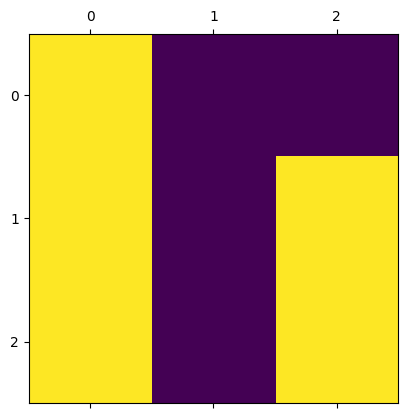

In [4]:
myMag = CreateMagnet(3)
print(myMag)
B = 0.3
nums = []
for i in range(10000):
    sweep(myMag, B)
    nums.append(ConvertToNumber(myMag))
DisplayMagnet(myMag)
print(myMag)
print(MeasureM2(myMag))

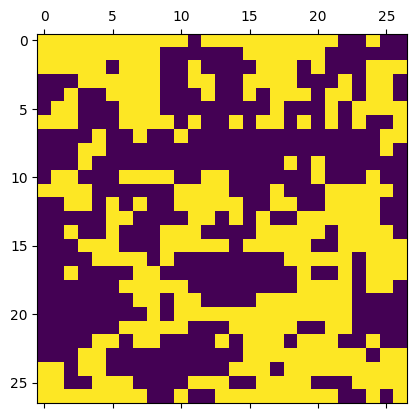

In [5]:
newmag = CreateMagnet(27)
beta = 0.3
MeasureThing(newmag, [], 100, beta)
DisplayMagnet(newmag)

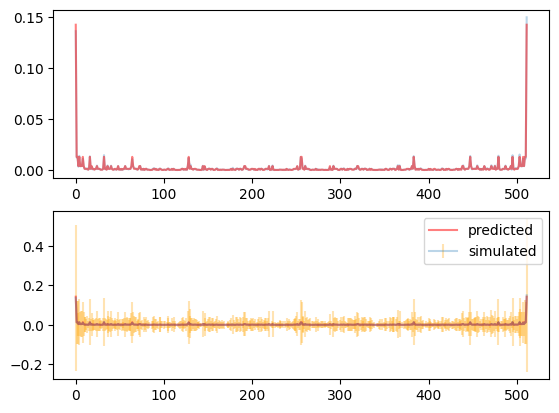

In [6]:
fig, ax = plt.subplots(2)
h = np.histogram(nums, bins = 2**9, density=True)
x = np.arange(0, 2**9)
b = ax[1].errorbar(x, h[0], yerr=np.sqrt(h[0]), alpha = 0.3, ecolor="orange", label="simulated")
b = ax[0].plot(x, h[0], alpha = 0.3, label = "simulated")
out = []
for i in range(2**9):
    binlen = 9
    bi = bin(i)[2:].zfill(binlen)
    close = np.array(list(bi), dtype=int)
    mag = (close.reshape(3, 3) * 2) - 1
    E = totalEnergy(mag)
    out.append(E)
    # print(E)
each = np.exp(-1 * np.array(out) * B)
each = each / sum(each)
# print(each)
ax[0].plot(x, each, alpha=0.5, label="predicted", color="red")
ax[1].plot(x, each, alpha=0.5, label="predicted", color="red")
plt.legend()
plt.show()

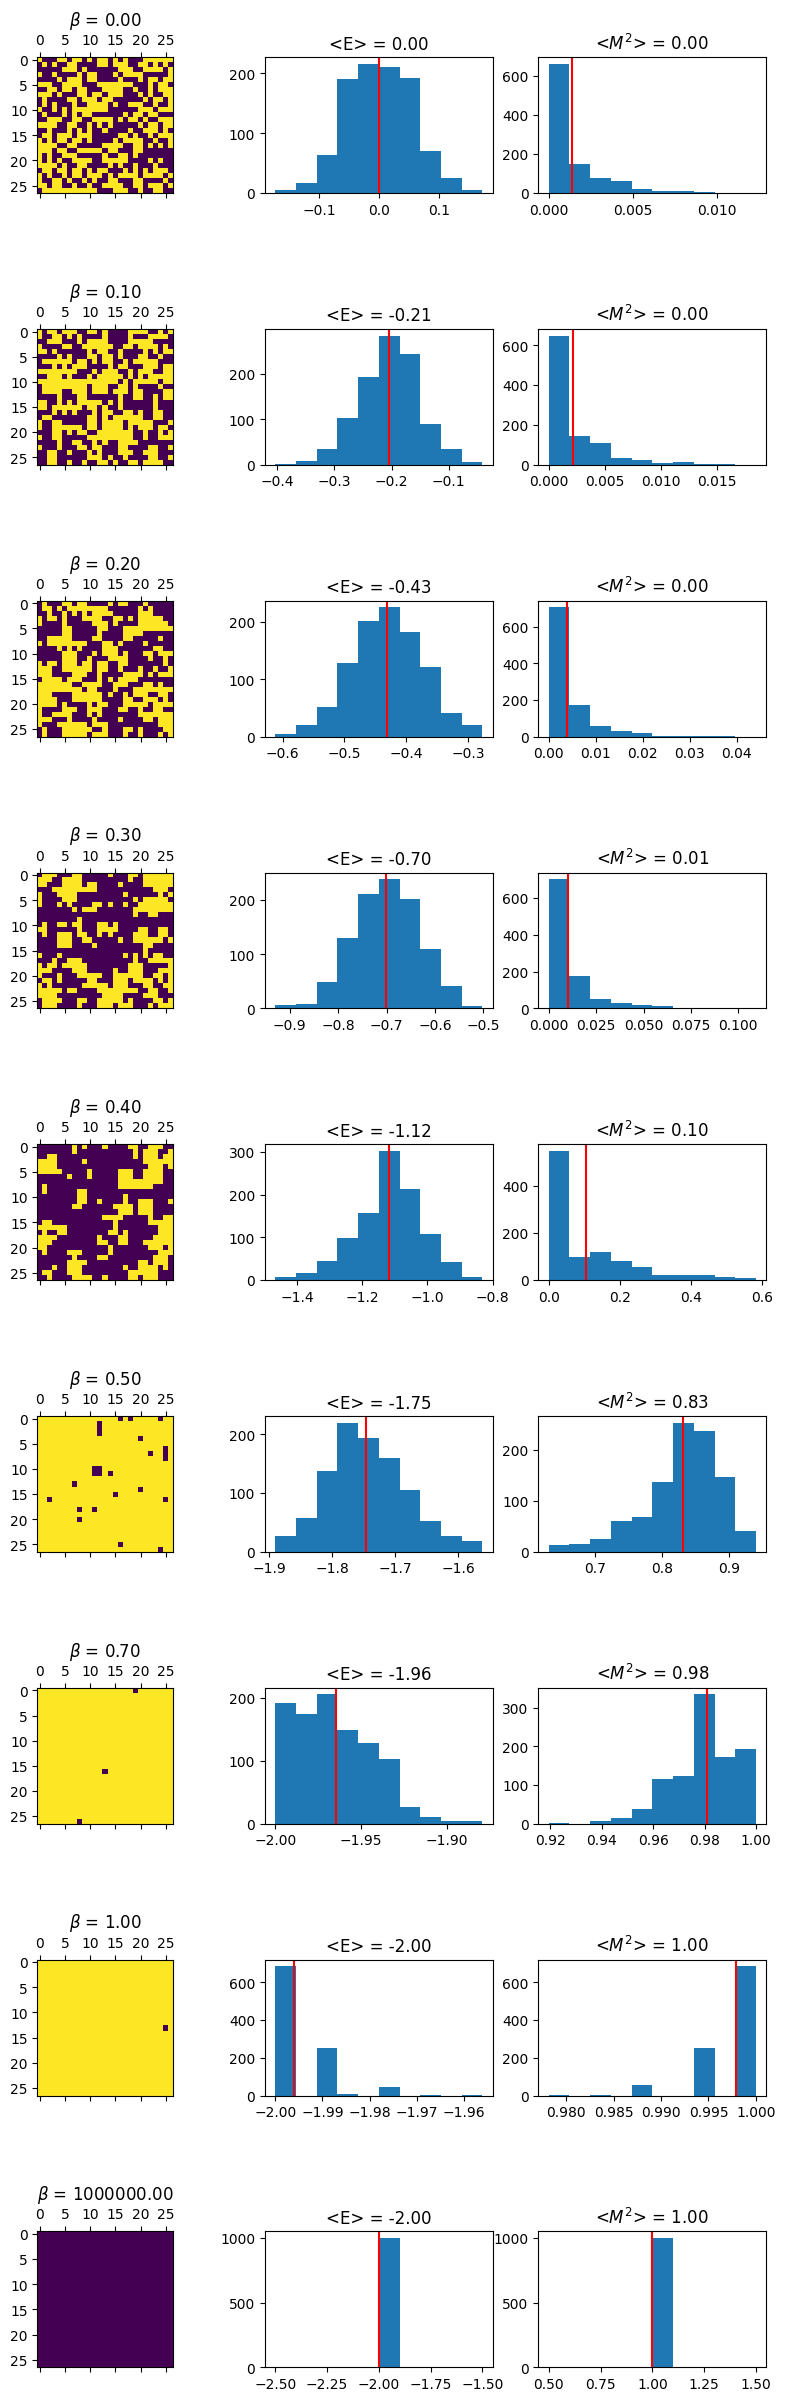

In [48]:

fig = plt.figure(figsize=(10, 30))
gs = fig.add_gridspec(9, 3, hspace=1)
axs = gs.subplots()
Betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1000000]
# Ts = [0.00001, 1, 1/0.8, 1/0.6, 1/0.4, 1/0.3, 1/0.2, 1/0.1, 1/0.00001]
for j in range(9):
    Mag2 = CreateMagnet(27)
    store = MeasureThing(Mag2, [totalEnergy, MeasureM2], 1000, Betas[j])
    E = np.array([i[0] for i in store]) / 27**2
    M2 = np.array([i[1] for i in store]) / 27**4
    hE = np.histogram(E)
    hM2 = np.histogram(M2)
    axs[j, 0].matshow(Mag2)
    axs[j, 0].set_title(r"$\beta$" + f" = {Betas[j]:.2f}")
    axs[j, 1].hist(E)
    axs[j, 1].axvline(E.mean(), color="red")
    axs[j, 1].set_title(f"<E> = {E.mean():.2f}")
    axs[j, 2].hist(M2)
    axs[j, 2].axvline(M2.mean(), color="red")
    axs[j, 2].set_title(r"<$M^2$>" + f" = {M2.mean():.2f}")
    
# x = np.arange(-100, 100, 200)
# axs[8, 1].plot(x, np.exp(-x**2), color="green")

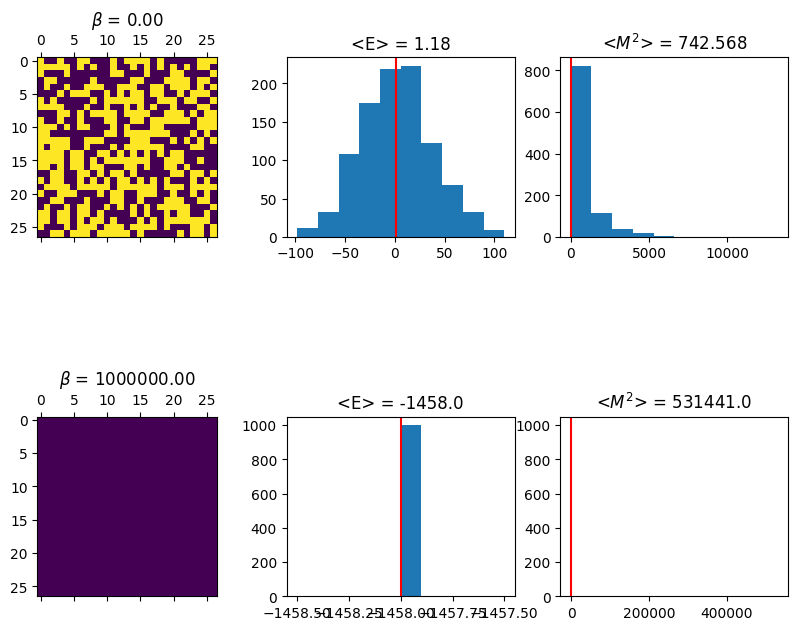

In [49]:
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 3, hspace=1)
axs = gs.subplots()
Betas = [0, 1000000]
for j in range(2):
    Mag2 = CreateMagnet(27)
    store = MeasureThing(Mag2, [totalEnergy, MeasureM2], 1000, Betas[j])
    E = np.array([i[0] for i in store])
    M2 = np.array([i[1] for i in store])
    hE = np.histogram(E)
    hM2 = np.histogram(M2)
    axs[j, 0].matshow(Mag2)
    axs[j, 0].set_title(r"$\beta$" + f" = {Betas[j]:.2f}")
    axs[j, 1].hist(E)
    axs[j, 1].axvline(E.mean(), color="red")
    axs[j, 1].set_title(f"<E> = {E.mean()}")
    axs[j, 2].hist(M2)
    axs[j, 2].axvline(E.mean(), color="red")
    axs[j, 2].set_title(r"<$M^2$>" + f" = {M2.mean()}")
x = np.arange(-100, 100, 100)
# axs[0, 1].plot(x, x*x)

In [10]:
# Generating Beta vs M^2 data
out = []
outerror = []
n = 10000
for i in range(0, 100):
    beta = i/100
    Mag = CreateMagnet(27)
    m = np.array(MeasureThing(Mag, [MeasureM2], n, beta)) # turn this number down to get it to run faster
    avg = np.mean(m)
    # m2 = np.sqrt(np.sum(np.power((m - avg), 2)) / n)
    realstd = np.std(m)
    # print(realstd - m2)
    out.append(avg)
    outerror.append(realstd)
    # print(avg)
x = np.linspace(0, 1, len(out))
# plt.plot(x, out)

Text(0, 0.5, '<$M^2$>')

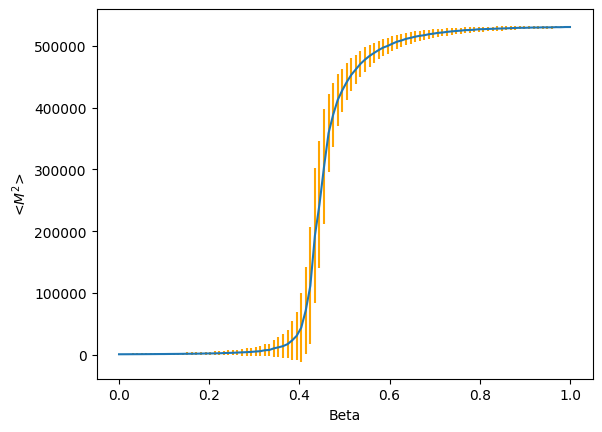

In [11]:
# Plotting M^2 for different Betas
plt.errorbar(x, out, yerr=outerror, alpha = 1, ecolor="orange", label="simulated")
plt.xlabel("Beta")
plt.ylabel(r"<$M^2$>")  

In [16]:
# Generating E vs B data
out = []
outerror = []
n = 1000 # turn this number down to get it to run faster
for i in tqdm.tqdm(range(0, 100)):
    beta = i/100
    Mag = CreateMagnet(27)
    m = np.array(MeasureThing(Mag, [totalEnergy], n, beta)) 
    avg = np.mean(m)
    # m2 = np.sqrt(np.sum(np.power((m - avg), 2)) / n)
    realstd = np.std(m)
    # print(realstd - m2)
    out.append(avg)
    outerror.append(realstd)
    # print(avg)
x = np.linspace(0, 1, len(out))

100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


Text(0, 0.5, '<$E$>')

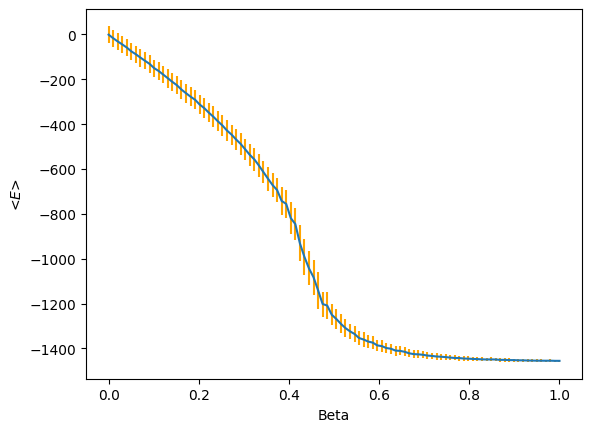

In [17]:
# Plotting E for different Betas
plt.errorbar(x, out, yerr=outerror, alpha = 1, ecolor="orange", label="simulated")
plt.xlabel("Beta")
plt.ylabel(r"<$E$>")  

Text(0.5, 0, '$\\beta$')

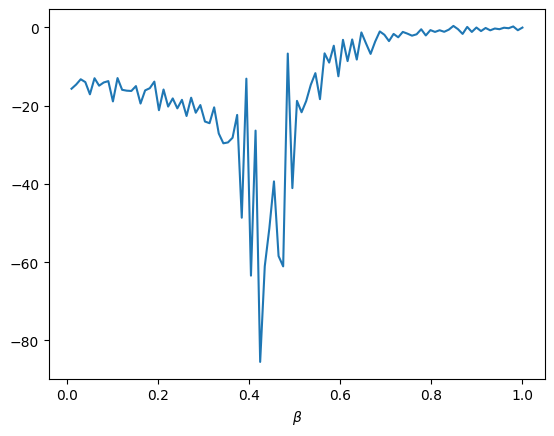

In [60]:
# plotting d/dB(E) to find specific heat
ddE = np.array(out[1:]) - np.array(out[:-1])
x2 = np.linspace(0.01, 1, len(ddE))
plt.plot(x2, ddE)
plt.xlabel(r"$\beta$")

Text(0, 0.5, 'Cv')

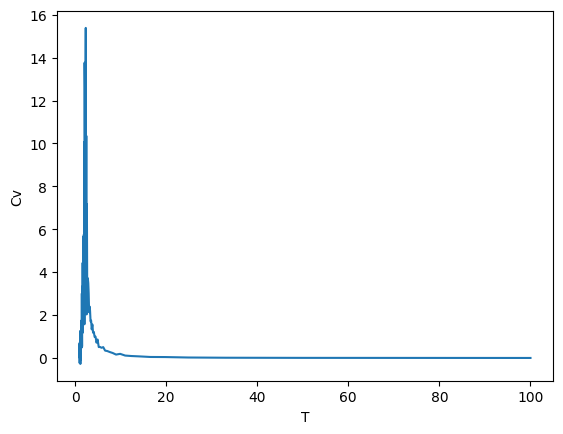

In [66]:
plt.plot(1/x2, -ddE*x2*x2)
plt.xlabel("T")
plt.ylabel("Cv")

100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


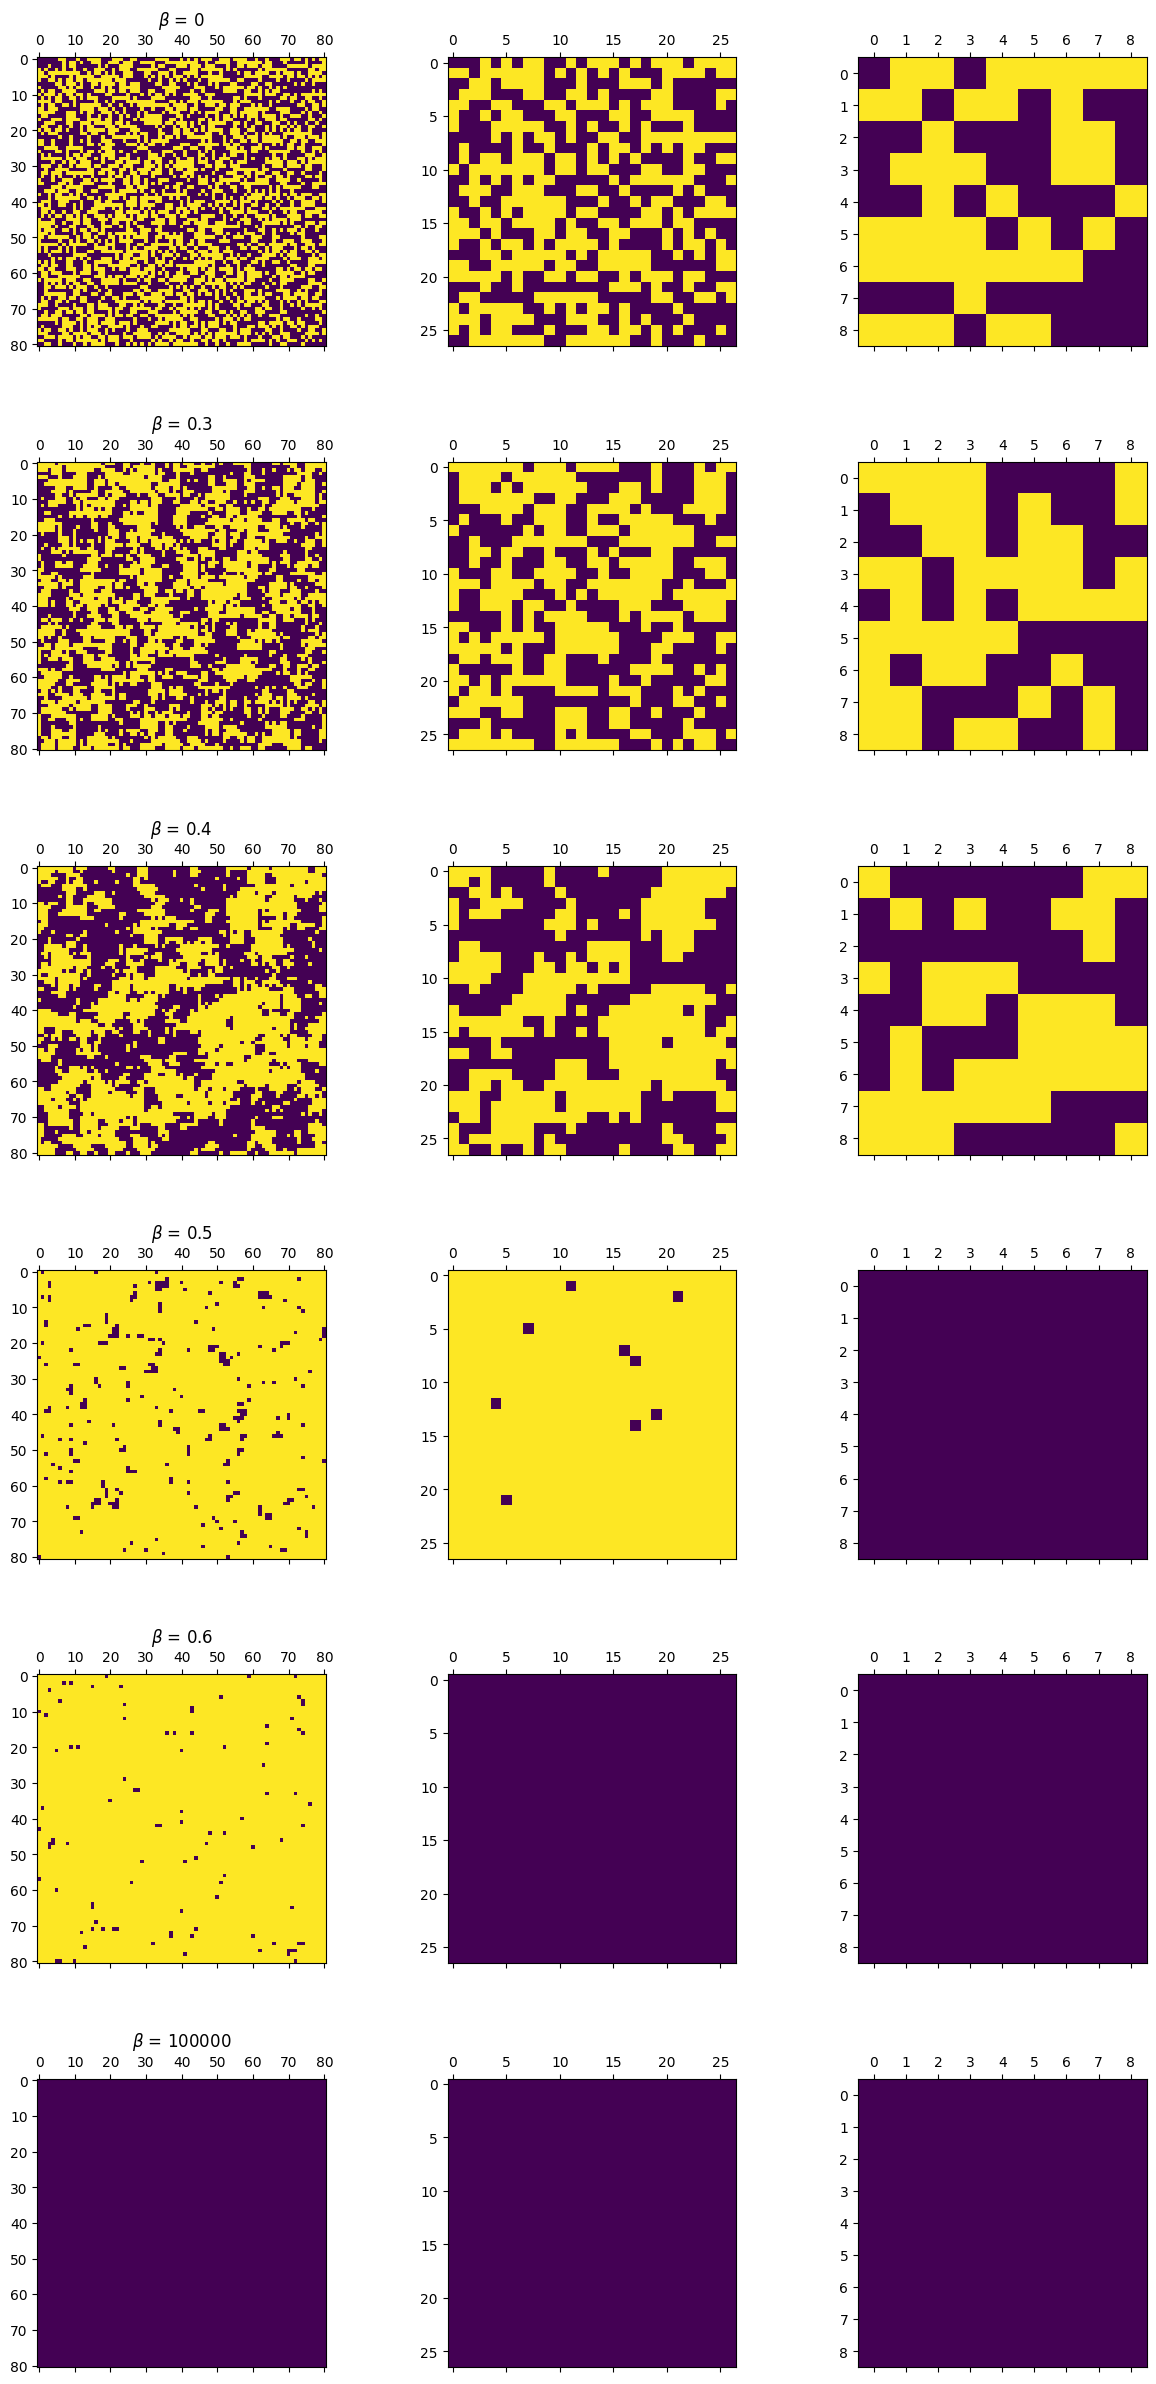

In [7]:
betas = [0, 0.3, 0.4, 0.5, 0.6, 100000]
fig = plt.figure(figsize=(15, 30))
gs = fig.add_gridspec(6, 3, hspace=0.4)
axs = gs.subplots()
for i in tqdm(range(len(betas))):
    b = betas[i]
    bigMag = CreateMagnet(81)
    a = MeasureThing(bigMag, [], 1000, b)
    axs[i, 0].matshow(bigMag)
    axs[i, 0].set_title(r"$\beta$" + f" = {b}")
    medMag = Renormalize(bigMag, 3)
    axs[i, 1].matshow(medMag)
    smolMag = Renormalize(medMag, 3)
    axs[i, 2].matshow(smolMag)

In [30]:
betas = np.linspace(0, 1, 20)
outLarge = []
outMed = []
for b in tqdm(betas):
    LargeMag = CreateMagnet(81)
    MedMag = CreateMagnet(27)
    tempLarge = []
    tempMed = []
    for j in range(10):
        sweep(LargeMag, b)
        sweep(MedMag, b)
    for j in tqdm(range(1000)):
        sweep(LargeMag, b)
        sweep(MedMag, b)
        tempLarge.append(MeasureM2(Renormalize(LargeMag, 3))/27**4)
        tempMed.append(MeasureM2(MedMag)/27**4)
    outLarge.append(np.mean(tempLarge))
    outMed.append(np.mean(tempMed))
    

100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


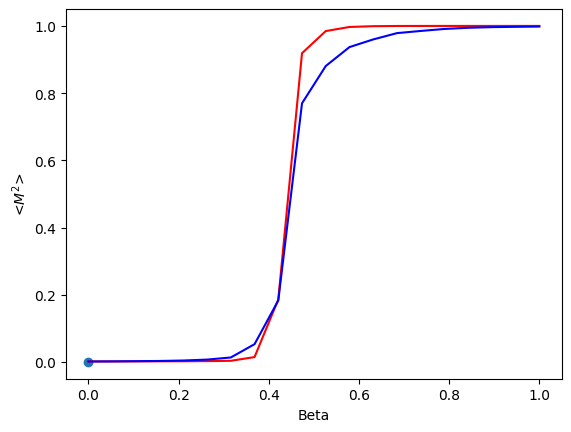

In [31]:
plt.plot(betas, outLarge, color = "red")
plt.plot(betas, outMed, color = "blue")
plt.xlabel("Beta")
plt.ylabel(r"<$M^2$>")
plt.scatter(0, 0)

0.0013137593143660495


Text(0, 0.5, 'R($\\beta$)')

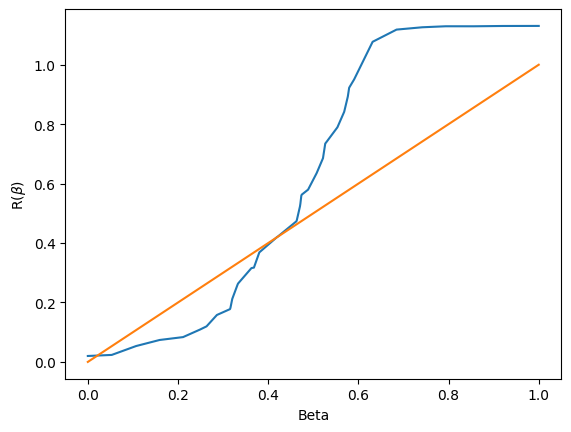

In [37]:
FL = interp1d(outMed, betas, fill_value="extrapolate")
FM = interp1d(betas, outLarge, fill_value="extrapolate")
def R(num):
    return FL(FM(num))
print(FM(FL(0)))
x = np.linspace(0, 1, 1000)
y = FL(FM(x))
plt.plot(x, FL(FM(x)))
plt.plot(x, x)
plt.xlabel("Beta")
plt.ylabel(r"R($\beta$)")

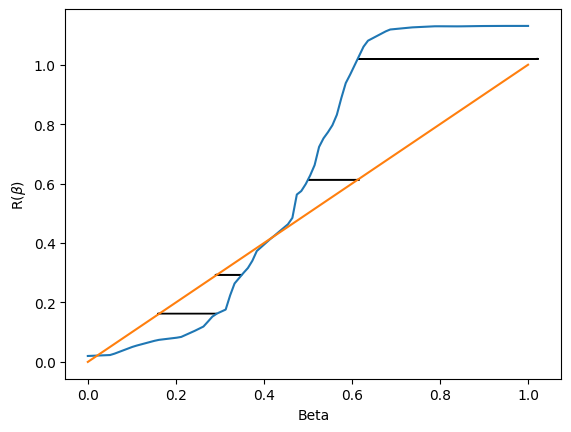

In [36]:
x = np.linspace(0, 1, 100)
plt.plot(x, FL(FM(x)))
plt.plot(x, x)
plt.xlabel("Beta")
plt.ylabel(r"R($\beta$)")
plt.arrow(0.35, R(0.35), R(0.35)-0.35,0)
plt.arrow(R(0.35), R(R(0.35)), R(R(0.35))-R(0.35),0)

plt.arrow(0.5, R(0.5), R(0.5)-0.5,0)
plt.arrow(R(0.5), R(R(0.5)), R(R(0.5))-R(0.5),0)

In [45]:
1/math.log(1.2, 3)

6.025685102665476